
So we have for our Hamiltonian for anyons as quasiparticles will be:

\begin{aligned}
\hat{H} &= -t \sum_{<ij>}
              \left(\hat{a}_i^\dagger\hat{a}_j e^{i \theta \hat{n}_j } + h.c. \right)
           + \frac{U}{2} \sum_{i=1}^M  \,\hat{n}_i \left(\hat{n}_i - 1\right) \\
        & 
\end{aligned}


## Simulation

In [527]:
using LinearAlgebra 
using Plots #Graph
using StaticArrays 
using SparseArrays #For sparse matrices 
using Arpack  #Eigenvalues and eigenvectors
using LaTeXStrings #Titles and labels 
using JLD #Save data
#definition of N,M,D
N=7
M=6
D=Int((factorial(M+N-1))/(factorial(M-1)*factorial(N)))  

#i-prime number function(suggested form) 
p(i)=100i+3 

#Generate a basis for N = M
function generate_basis(N, M, D)
    #D = prod(max(N, M):N+M-1) ÷ prod(1:min(N, M))
    basis = [zeros(Int, M) for _ in 1:D]
    basis[1][1] = N
    for t = 2:D
        if basis[t-1][M] != 0
            k = M - 1
        else
            k = M
        end
        while k > 0 && basis[t-1][k] == 0
            k -= 1
        end
        @views basis[t][1:k-1] .= basis[t-1][1:k-1]
        basis[t][k] = basis[t-1][k] - 1
        basis[t][k+1] = N - sum(@view(basis[t][1:k])) 
        end 
    return basis 
end 
#if you are struggling with the lexicographic order, you can think this algorithm as a game of balls on different 
#sites, for example for 3 balls and 3 sites, you start with 3 in the first site, then 1 ball fall from 
#the first site and going to the second site and finally the ball which fallen moves to the third site
#and now you repeat the process of drop a ball on the first place and then move it on each site until the last.
v = generate_basis(N,M,D)

792-element Vector{Vector{Int64}}:
 [7, 0, 0, 0, 0, 0]
 [6, 1, 0, 0, 0, 0]
 [6, 0, 1, 0, 0, 0]
 [6, 0, 0, 1, 0, 0]
 [6, 0, 0, 0, 1, 0]
 [6, 0, 0, 0, 0, 1]
 [5, 2, 0, 0, 0, 0]
 [5, 1, 1, 0, 0, 0]
 [5, 1, 0, 1, 0, 0]
 [5, 1, 0, 0, 1, 0]
 [5, 1, 0, 0, 0, 1]
 [5, 0, 2, 0, 0, 0]
 [5, 0, 1, 1, 0, 0]
 ⋮
 [0, 0, 0, 1, 3, 3]
 [0, 0, 0, 1, 2, 4]
 [0, 0, 0, 1, 1, 5]
 [0, 0, 0, 1, 0, 6]
 [0, 0, 0, 0, 7, 0]
 [0, 0, 0, 0, 6, 1]
 [0, 0, 0, 0, 5, 2]
 [0, 0, 0, 0, 4, 3]
 [0, 0, 0, 0, 3, 4]
 [0, 0, 0, 0, 2, 5]
 [0, 0, 0, 0, 1, 6]
 [0, 0, 0, 0, 0, 7]

In [528]:
#tag function
function tag(b,M)
    tag=0;
    for i in 1:M
        tag += (√p(i))*b[i] 
    end
    return tag 
end

tag (generic function with 1 method)

In [529]:
#Creation-Annihilation with phase
function creation_ann(k,j,v)     
    if(v[j] >= 1) 
        b = copy(v)
        value = sqrt(((b[k])+1)*b[j])
        b[j] -= 1; 
        b[k] += 1;    
        #m = findfirst(i -> i == b, v ) ### v here is not defined as basis!
        #valued = occupationdependamplitude(pi/3, k)[m,m]
        return [value , b]   
    else 
        return 0; 
    end 
end   

creation_ann (generic function with 1 method)

In [530]:
b = findfirst(i -> i == creation_ann(1,3,v[3])[2], v)
#println(indexin(creation_ann(2,1,v[1])[2],v)[1])
#occupationdependamplitude(theta, 2)[2,2]*(creation_ann(2,1,v[1])[1])
#real(diag(occupationdependamplitudeup(pi/3,3))[b])

1

In [531]:
creation_ann(2,1,v[1])[1]

2.6457513110645907

In [532]:
function matrixofcreationann(i,k)
    mat = spzeros(D,D)
    for j in 1:D 
        if creation_ann(i,k,v[j]) == 0 
           continue      
        end
        mat[DictOfInds[tag(creation_ann( i, k , v[j] )[2],M)], j] = creation_ann(i, k , v[j])[1] 
    end    
    return mat
end

matrixofcreationann (generic function with 1 method)

In [533]:
#Diagonal values of the occupation number
function valdiags(k, v, M)  
    if(v[k] >= 1)  
        return  (v[k]*(v[k]-1))/2  
    else 
        return 0;
    end  
end       

valdiags (generic function with 1 method)

In [534]:
function occupation(i, v) 
     if(v[i] >= 1)  
        return  v[i]  
    else 
        return 0;
    end  
end       

occupation (generic function with 1 method)

In [535]:
function matrixoccupation(k, D) 
    mat = spzeros(Complex{Float16}, D,D)
    for j in 1:D 
        mat[j,j] = occupation(k, v[j]) 
    end   
    return mat 
end

matrixoccupation (generic function with 1 method)

In [536]:
#Array of tags 
T = []
for i in 1:length(v) 
     push!(T,  tag( v[i] , M )) 
end

In [537]:
#Order and we made a dictionary to Tsorted => indices
inds = sortperm(T);
Tsorted = T[inds];
#DictOfInds = Dict(zip(Tsorted, inds)) 
DictOfInds = Dict(Tsorted .=> inds)

Dict{Float64, Int64} with 792 entries:
  127.906 => 313
  114.373 => 101
  133.643 => 354
  79.2401 => 7
  113.608 => 292
  111.771 => 264
  102.633 => 43
  105.41  => 96
  108.272 => 288
  128.355 => 318
  142.805 => 618
  149.396 => 740
  118.314 => 295
  107.897 => 139
  112.262 => 271
  123.916 => 335
  149.954 => 638
  122.17  => 211
  137.432 => 439
  149.08  => 724
  162.93  => 777
  153.113 => 722
  135.928 => 574
  123.601 => 331
  124.299 => 212
  ⋮       => ⋮

In [538]:
#Matrices
# #dependent h.c. occupational operator exp(-iθnᵢ)  
# function occupationdependamplitudeup(theta, k)
#     if theta == 0 
#         return Matrix(1I, D, D)
#     else
#         return exp(-1im*theta*Matrix(matrixoccupation(k,D)))  
#     end
# end   
# ############################################### 
# #dependent occupational operator exp(iθnⱼ)  
# function occupationdependamplitudedown(theta, k) 
#     if theta == 0 
#         return Matrix(1I, D, D)
#     else
#         return exp(1im*theta*Matrix(matrixoccupation(k,D)))  
#     end
# end  

In [539]:
#new operator 
function expop(theta, t, v ) 
     if(v[t] >= 1)  
        return  exp(1im*theta*v[t])
    else 
        return 1
    end  
end     
###HC 
#new operator 
function expophc(theta, t, v) 
     if(v[t] >= 1)  
        return  exp(-1im*theta*v[t])
    else 
        return 1
    end  
end    

expophc (generic function with 1 method)

In [540]:
#for j in 1:D
#creation_ann(2,1,v[1])[2] == v[2]
expop(pi/2, 2, v[1] )
#end

1

In [541]:
#occupationdependamplitudedown(pi, 1)

In [542]:
theta = pi
Htheta = spzeros(Complex{Float64}, D, D)  
HthetaHC = spzeros(Complex{Float64}, D, D)  

for j in 1:D, k in 1:M, m in 1:M   
    if creation_ann(k,m,v[j]) == 0 
        continue     
    end 
    pos = DictOfInds[tag(creation_ann( k, m , v[j] )[2], M)] 
    
    if (abs(k-m)==(M-1) || abs(k-m)==1 ) ##Boundary condition 1->M, M->1            
        if(pos < j)   #### up  part    
            #HthetaHC[pos, j] = occupation(m, v[j]) #Checking the numbers of occupation 
          HthetaHC[pos, j] = expophc(theta, m, v[j]) 
        end
        if(pos > j) ### down  part 
            #Htheta[pos, j] = occupation(k, creation_ann( k, m , v[j] )[2])  #Checking the numbers of occupation 
            Htheta[pos, j] =  expop(theta, k, creation_ann( k, m , v[j] )[2])  
        end
    end 
    #end
end     
Htheta+HthetaHC;

In [543]:
diagscomp = [] 

for j in 1:D 
    sumsdeocup = []; 
    for k in 1:M
        push!(sumsdeocup, valdiags(k, v[j], M))
    end  
    push!(diagscomp, sum(sumsdeocup))    
end   
#Mostramos la parte  
U=1
Vals = U*diagscomp
Hint = spzeros(D,D)
Hint[diagind(Hint)] = Vals; Hint   


J = 1 
Hkin = spzeros(Complex{Float64}, D, D)  
HkinHC = spzeros(Complex{Float64}, D, D)  

for j in 1:D, k in 1:M, m in 1:M   
    if creation_ann(k,m,v[j]) == 0 
        continue     
    end
        if (abs(k-m)==(M-1) || abs(k-m)==1 ) ##Boundary condition 1->M, M->1            
            if(DictOfInds[tag(creation_ann( k, m , v[j] )[2],M)] < j)   #### up  part  
                HkinHC[DictOfInds[tag( creation_ann( k, m , v[j])[2] ,M)], j] = -J*(creation_ann( k, m , v[j])[1])#*expophc(theta, k, creation_ann(k,m, v[j])[2])#*expophc(theta, k, v[mod(j,D)+1])[mod(j,D)+1][mod(j,D)+1]  
            end
            if(DictOfInds[tag(creation_ann( k, m , v[j] )[2],M)] > j) ### down  part
            Hkin[DictOfInds[tag( creation_ann( k, m , v[j])[2] ,M)], j] = -J*(creation_ann( k, m , v[j])[1])#*expop(theta, m, v[j]) #*expop(theta, k, v[j])[j][j]   
            end
        end    
      
end     

H= Hint + Hkin.*Htheta  + HkinHC.*HthetaHC;

#spy(H, markersize = 5)

In [544]:
Eval, Evec = eigs(H , nev=1 , which=:SR)

(ComplexF64[-8.180576538687065 + 5.646054158538489e-17im], ComplexF64[3.3297726133027184e-5 + 4.279668494195694e-5im; -0.00016761385242622856 - 0.00021542964241911245im; … ; -0.00016761385242623788 - 0.00021542964241906142im; 3.329772613299172e-5 + 4.279668494209282e-5im], 1, 10, 110, ComplexF64[-0.5289872843549281 + 1.4092056504946884im, -0.27077027662999426 + 0.0945920884399349im, 0.12152957059446995 - 0.18961758081456495im, 0.6350877950667595 - 0.2723135711733906im, 0.5211820067186281 - 0.5512090084396858im, 0.4884993821681175 + 0.03610848432542671im, 0.0684779733976554 + 0.1366288709581037im, -0.008443973359661103 - 0.06942278040023792im, 0.49501842094140674 + 0.0074452128046341316im, 0.4385901311637003 - 0.2051337477580979im  …  0.4724544550905283 - 0.07376513090327817im, -0.1762542018652103 + 0.22485491568147442im, 0.7397317755284134 - 0.06039908446708653im, 0.28799135796829284 + 0.89885065543847im, -0.3043973651410318 - 0.7018299092664271im, 0.24634720446418737 - 0.8123221278120

In [545]:
diagscomp = [] 
#theta = pi/3
for j in 1:D 
    sumsdeocup = []; 
    for k in 1:M
        push!(sumsdeocup, valdiags(k, v[j], M))
    end  
    push!(diagscomp, sum(sumsdeocup))    
end   
#Mostramos la parte  
U=1
Vals = U*diagscomp
Hint = spzeros(D,D)
Hint[diagind(Hint)] = Vals; Hint   


#lowerbound = []  
#lowerboundminus = [] 
lowerboundplus = [] 

for t in 0:0.05:0.5 
#     Another solution but is really slow!
#     J = t 
#     Hkin = spzeros(Complex{Float64}, D, D)  

#     for j in 1:D, k in 1:M, m in 1:M   
#         if creation_ann(k,m,v[j]) == 0 
#             continue     
#         elseif (abs(k-m)==(M-1) || abs(k-m)==1 ) ##Boundary condition 1->M, M->1            
#             if(DictOfInds[tag(creation_ann( k, m , v[j] )[2],M)] < j)   #### up  part 
#                 b = findfirst(i -> i == creation_ann(k, m, v[j])[2] , v) 
#                 valueofexp = diag(occupationdependamplitudeup(theta, k))[b]
#                 Hkin[DictOfInds[tag( creation_ann( k, m , v[j])[2] ,M)], j] = -J*(creation_ann( k, m , v[j])[1])*valueofexp 
#             end
#             if(DictOfInds[tag(creation_ann( k, m , v[j] )[2],M)] > j) ### down  part
#                 b = findfirst(i -> i == creation_ann(k, m, v[j])[2] , v) 
#                 valueofexp = diag(occupationdependamplitudedown(theta, k))[b]
#                 Hkin[DictOfInds[tag( creation_ann( k, m , v[j])[2] ,M)], j] = -J*(creation_ann( k, m , v[j])[1])*valueofexp        
#             end   
#         end   
#     end     
#     H=Hkin+Hint 
    J = t 
    Hkin = spzeros(Complex{Float64}, D, D)  
    HkinHC = spzeros(Complex{Float64}, D, D)  

    for j in 1:D, k in 1:M, m in 1:M   
        if creation_ann(k,m,v[j]) == 0 
            continue     
        end
        if (abs(k-m)==(M-1) || abs(k-m)==1 ) ##Boundary condition 1->M, M->1            
            if(DictOfInds[tag(creation_ann( k, m , v[j] )[2],M)] < j)   #### up  part  
                HkinHC[DictOfInds[tag( creation_ann( k, m , v[j])[2] ,M)], j] = -J*(creation_ann( k, m , v[j])[1])#*expophc(theta, k, creation_ann(k,m, v[j])[2])#*expophc(theta, k, v[mod(j,D)+1])[mod(j,D)+1][mod(j,D)+1]  
            end
            if(DictOfInds[tag(creation_ann( k, m , v[j] )[2],M)] > j) ### down  part
                Hkin[DictOfInds[tag( creation_ann( k, m , v[j])[2] ,M)], j] = -J*(creation_ann( k, m , v[j])[1])#*expop(theta, m, v[j]) #*expop(theta, k, v[j])[j][j]   
            end
        end      
    end     

    H= Hint + Hkin.*Htheta  + HkinHC.*HthetaHC
    Eval, Evec = eigs(H , nev=1 , which=:SR)  
    #push!(lowerbound, real(Eval[1]) )  
    #push!(lowerboundminus, real(Eval[1]) )  
    push!(lowerboundplus, real(Eval[1]) )     
end

In [310]:
lowerbound

11-element Vector{Any}:
  9.814215770834177e-16
 -0.059913719176406796
 -0.2404620479947474
 -0.5440867414471673
 -0.9512992246528691
 -1.4225483501461185
 -1.9296005498169013
 -2.4580261828058996
 -3.000404298149472
 -3.5525580833541017
 -4.1119247025147825

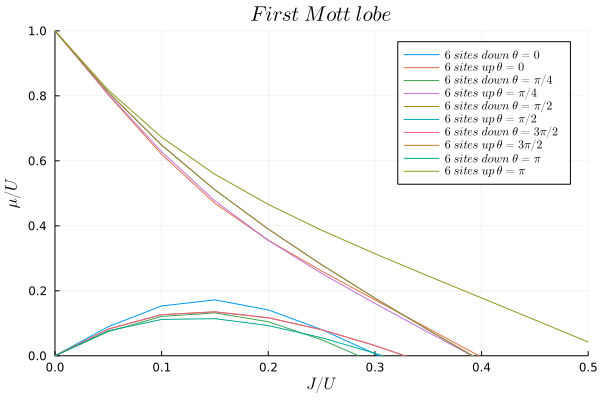

In [546]:
t = 0:0.05:0.50
plot!(t,lowerbound-lowerboundminus , xlabel =L"J/U", ylabel=L"\mu/U", title =L"First~Mott~lobe", label =L"6~sites~down~\theta =  \pi ", xlims=(0, 0.50), ylims=(0,1))
plot!(t,lowerboundplus-lowerbound , xlabel =L"J/U", ylabel=L"\mu/U", title =L"First~Mott~lobe", label =L"6~sites~up~\theta =  \pi ", xlims=(0, 0.50), ylims=(0,1))

#savefig("plotofchemsBH.png")

In [547]:
savefig("PhaseDiagramAnyon-BH.png")

In [270]:
Eval, Evec = eigs(H , nev=2 , which=:SR)

(ComplexF64[-4.1119247025147985 - 4.692583886688743e-17im, -3.0984643654405026 - 4.775585059249691e-17im], ComplexF64[-4.613547229322292e-5 - 2.3841424526409537e-6im -0.00011525323666387933 - 4.9986626878360255e-5im; -0.00035996789746927673 - 1.8602058314021725e-5im -0.0008858283842198331 - 0.00022261901273135605im; … ; -0.0003599678974692855 - 1.860205831403374e-5im -8.180413296072395e-5 - 0.0012146161273424191im; -4.613547229321166e-5 - 2.384142452632387e-6im -2.6105929892612423e-5 - 0.00015997568623063327im], 2, 7, 125, ComplexF64[-0.28606132894082936 + 0.23289792967593845im, -0.5658259306245577 + 0.32524772823734144im, 0.051526708723376474 + 0.24590098024186208im, -0.19370490184798028 - 0.3151429141604578im, 0.34834128011469756 - 0.10801861610467484im, -0.13319437273339788 + 0.22928429324806748im, 0.07123965200550159 - 0.3415982124124748im, 0.04941853522589837 - 0.13805400401616066im, 0.1372890745537431 + 0.07598784951997635im, -0.08250489115314 + 0.07507356743680611im  …  0.010569

In [271]:
G = Evec[:,1] 

462-element Vector{ComplexF64}:
   -4.613547229322292e-5 - 2.3841424526409537e-6im
 -0.00035996789746927673 - 1.8602058314021725e-5im
  -0.0007153088937888375 - 3.696501229232304e-5im
  -0.0008891955407230826 - 4.5950951230338217e-5im
  -0.0007153088937888466 - 3.6965012292314054e-5im
  -0.0003599678974692656 - 1.8602058314012946e-5im
  -0.0012038325981993468 - 6.221044806900126e-5im
   -0.003888643425922434 - 0.00020095339690006674im
   -0.005291856840568022 - 0.00027346724591202073im
   -0.004581406343923637 - 0.00023675330097217782im
   -0.002470635773415831 - 0.0001276750261700752im
   -0.003380153294489326 - 0.00017467615622519851im
   -0.008082139300752092 - 0.00041766065149578623im
                         ⋮
  -0.0024706357734158254 - 0.0001276750261700647im
   -0.006928431602244676 - 0.00035804050748895327im
   -0.008141162831301132 - 0.00042071081003741033im
   -0.003888643425922428 - 0.00020095339690007089im
  -0.0007153088937888532 - 3.696501229232152e-5im
   -4.613547229316